# A transfer-learnt student model from Teacher model EfficientNet by unfreezing some existing layers

In [2]:
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from lime import lime_image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.optimizers import Adam
from skimage.segmentation import mark_boundaries
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7, EfficientNetB3

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

In [5]:
pd.set_option('display.max_colwidth', None)
df = pd.read_csv('/kaggle/input/facescls/FaceExpressions/data.csv', index_col=0)
df.head()

path  \
0  Surprise/1bd930d6a1c717c11be33db74823f661cb53f86cbba1d3d1f336cdf9~12fffff.jpg   
1                                   Surprise/cropped_emotions.100096~12fffff.png   
2  Surprise/0df0e470e33093f5b72a8197fa209d684032cc17f68194e605a26897~12fffff.jpg   
3                                   Surprise/cropped_emotions.260779~12fffff.png   
4                                   Surprise/cropped_emotions.263616~12fffff.png   

      label  
0  Surprise  
1  Surprise  
2  Surprise  
3  Surprise  
4  Surprise

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='label', ylabel='Count'>

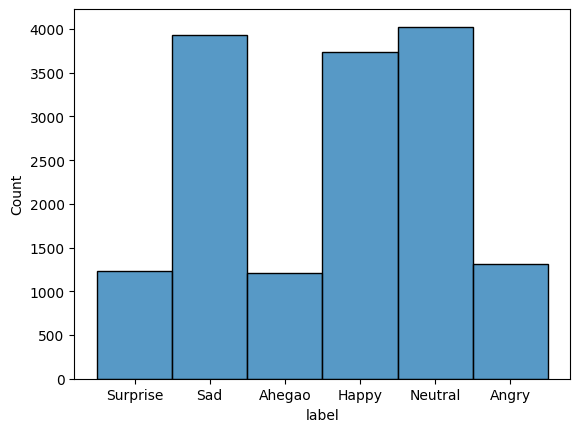

In [6]:
sns.histplot(df["label"])

In [7]:
df["label"].value_counts()

label
Neutral     4027
Sad         3934
Happy       3740
Angry       1313
Surprise    1234
Ahegao      1205
Name: count, dtype: int64

## Datasets are not balanced, so we need to split it and balance the training set.

In [8]:
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['label'])
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42, stratify=train_val_df['label'])

In [9]:
train_df.shape, val_df.shape, test_df.shape

((12516, 2), (1391, 2), (1546, 2))

## Balancing the training set

In [10]:
max_value_counts = train_df['label'].value_counts().max()

oversampled_df = []

for _, group in train_df.groupby('label'):
    oversampled_group = resample(group,
                                 replace=True,  
                                 n_samples=max_value_counts,  
                                 random_state=42)  
    oversampled_df.append(oversampled_group)

balanced_train_df = pd.concat(oversampled_df)
balanced_train_df = shuffle(balanced_train_df, random_state=42)

In [11]:
train_df['label'].value_counts()

label
Neutral     3261
Sad         3186
Happy       3029
Angry       1064
Surprise    1000
Ahegao       976
Name: count, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='label', ylabel='Count'>

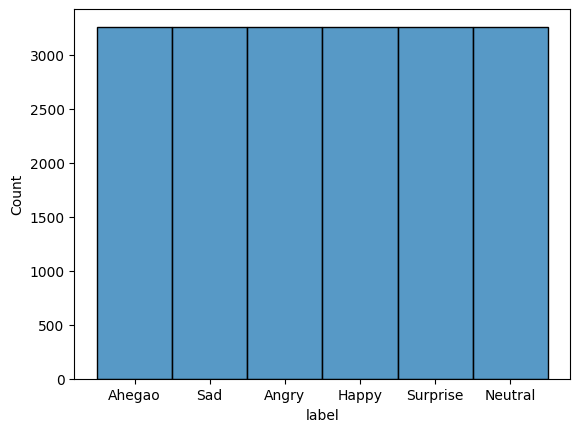

In [12]:
sns.histplot(balanced_train_df["label"])

## Function to apply Gaussian Blur using 3x3 window. Will be used in the ImageDataGenerator

In [13]:
def preprocess_imgs(img):
    img_uint8 = (img * 255).astype('uint8')
    img_blur = cv2.GaussianBlur(img_uint8, (3, 3), 0)
    
    return img_blur.astype('float32') / 255

## Data generator for tensorflow using ImageDadaGenerator

In [14]:
base_dir = '/kaggle/input/facescls/FaceExpressions/dataset'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
#     preprocessing_function=preprocess_imgs, # Gaussian Blur was not giving good results
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=balanced_train_df,
    directory=base_dir,  
    x_col='path',
    y_col='label',
    target_size=(96, 96),
    batch_size=64,
    class_mode='categorical'
)

Found 19566 validated image filenames belonging to 6 classes.


## Validation and testing will use the same generator. Using flow_from_dataframe to use path from dataframe and images from base_dir. Also, identify labels from "label" column from dataframe

In [15]:
val_and_test_datagen = ImageDataGenerator(
    rescale=1./255,
#     preprocessing_function=preprocess_imgs,
)

validation_generator = val_and_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=base_dir,
    x_col='path',
    y_col='label',
    target_size=(96, 96), 
    batch_size=64,
    class_mode='categorical'
)

test_generator = val_and_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=base_dir,
    x_col='path',
    y_col='label',
    target_size=(96, 96), 
    batch_size=64,
    class_mode='categorical',
    shuffle=False 
)

Found 1391 validated image filenames belonging to 6 classes.
Found 1546 validated image filenames belonging to 6 classes.


## Balanced dataset for training containing 3261 images from each class

In [16]:
balanced_train_df['label'].value_counts()

label
Ahegao      3261
Sad         3261
Angry       3261
Happy       3261
Surprise    3261
Neutral     3261
Name: count, dtype: int64

# Training the EfficientNet B0 model with last 2 layers unfreezed

In [25]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
op = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=op)

for layer in base_model.layers[-2:]:
    layer.trainable = True

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 10
model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/612 ━━━━━━━━━━━━━━━━━━━━ 16:59:57 100s/step - accuracy: 0.1562 - loss: 1.7984

I0000 00:00:1711939503.545005      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


612/612 ━━━━━━━━━━━━━━━━━━━━ 569s 767ms/step - accuracy: 0.3113 - loss: 1.6355 - val_accuracy: 0.0848 - val_loss: 1.8381
Epoch 2/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 373s 602ms/step - accuracy: 0.3977 - loss: 1.4515 - val_accuracy: 0.0848 - val_loss: 2.2646
Epoch 3/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 375s 605ms/step - accuracy: 0.4482 - loss: 1.3531 - val_accuracy: 0.2531 - val_loss: 2.7118
Epoch 5/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 372s 601ms/step - accuracy: 0.4689 - loss: 1.3140 - val_accuracy: 0.2509 - val_loss: 1.7695
Epoch 6/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 372s 601ms/step - accuracy: 0.4827 - loss: 1.2879 - val_accuracy: 0.2682 - val_loss: 1.7547
Epoch 7/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 377s 609ms/step - accuracy: 0.4989 - loss: 1.2310 - val_accuracy: 0.2581 - val_loss: 1.9604
Epoch 9/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 377s 609ms/step - accuracy: 0.5050 - loss: 1.2149 - val_accuracy: 0.0848 - val_loss: 2.7020
Epoch 10/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 372s 601ms/step - accuracy: 0.5197 - loss: 1.1

# Tuning 1:
- Increase batch_size to 64
- drop_connect_rate=0.4
- Add dropout 0.4 because of overfitting.
- Unfreeze 2 more layers, unfreezing 4 layers in total.
- learning rate to 0.0001

In [34]:
model_2.save('/kaggle/working/model_2.h5')

In [16]:
model_2 = load_model('/kaggle/input/checkpoint/model_2.h5')

In [30]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3), drop_connect_rate=0.3)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
op = Dense(6, activation='softmax')(x)

model_2 = Model(inputs=base_model.input, outputs=op)

for layer in base_model.layers[-4:]:
    layer.trainable = True

model_2.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_2.fit(train_generator,
          epochs=10,
          validation_data=validation_generator)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1711994710.717419      80 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


306/306 ━━━━━━━━━━━━━━━━━━━━ 579s 2s/step - accuracy: 0.2689 - loss: 1.7060 - val_accuracy: 0.2545 - val_loss: 1.6875
Epoch 2/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.3585 - loss: 1.5296 - val_accuracy: 0.2545 - val_loss: 2.0217
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.4024 - loss: 1.4292 - val_accuracy: 0.2531 - val_loss: 2.0329
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.4274 - loss: 1.3888 - val_accuracy: 0.1438 - val_loss: 54.0200
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.4429 - loss: 1.3643 - val_accuracy: 0.2682 - val_loss: 2.2513
Epoch 7/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.4511 - loss: 1.3366 - val_accuracy: 0.2912 - val_loss: 2.7578
Epoch 8/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.4682 - loss: 1.3100 - val_accuracy: 0.2761 - val_loss: 2.0383
Epoch 9/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.4799 - loss: 1.2760 - val_accuracy: 0.24

## Saving the model

In [48]:
model_2.save('/kaggle/working/model_2.1.h5')

# Tuning 2:
- Use efficientnet B7 
- EfficientNetb7 expects input size of 600 x 600. Need to do all the preprocessing again.
- Changed image size in previous preprocessing steps
- Unfreeze more layers
- dropout value increase to 0.4
- Decrease the batch size to 32 

In [16]:
base_model_b7 = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(600, 600, 3), drop_connect_rate=0.4)
x = base_model_b7.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
op = Dense(6, activation='softmax')(x)

model_3 = Model(inputs=base_model_b7.input, outputs=op)

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
for layer in base_model_b7.layers[-10:]:
    layer.trainable = True

model_3.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_3.fit(train_generator,
          epochs=10,
          validation_data=validation_generator)

## Unfortunately, we do not have sufficient resources, as buffer size filled fast and we ran out of GPU Memory. But we can try on Efficient Net B3.

### As mentioned in this paper, https://ieeexplore.ieee.org/document/10053007:
### Efficient Net B3 was the best model for face expressions.

## Let's use the EfficientNetB3 now.

# Tuning 3:
- Found out that Gaussian Blur was creating problem in training so, removed the Gaussian Blur.
- Use efficientnet B3 
- Changed image size to 96x96 in previous preprocessing steps
- Unfreeze 2 layers
- dropout value increase to 0.4
- Increase the batch size to 64 
- Decrease Dense layer nodes to 128

In [38]:
base_model_b3 = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(96, 96, 3), drop_connect_rate=0.4)
x = base_model_b3.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
op = Dense(6, activation='softmax')(x)

model_3 = Model(inputs=base_model_b3.input, outputs=op)

In [39]:
for layer in base_model_b3.layers[-2:]:
    layer.trainable = True

model_3.compile(optimizer=Adam(learning_rate=0.001), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_3.fit(train_generator,
          epochs=10,
          validation_data=validation_generator)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


306/306 ━━━━━━━━━━━━━━━━━━━━ 373s 781ms/step - accuracy: 0.5790 - loss: 1.1037 - val_accuracy: 0.2646 - val_loss: 2.1494
Epoch 2/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 154s 493ms/step - accuracy: 0.8042 - loss: 0.5368 - val_accuracy: 0.6298 - val_loss: 1.2093
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 160s 512ms/step - accuracy: 0.8439 - loss: 0.4232 - val_accuracy: 0.7304 - val_loss: 0.8235
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 158s 505ms/step - accuracy: 0.8755 - loss: 0.3409 - val_accuracy: 0.7872 - val_loss: 0.6110
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 157s 501ms/step - accuracy: 0.8870 - loss: 0.3172 - val_accuracy: 0.7779 - val_loss: 0.6188
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 155s 496ms/step - accuracy: 0.8978 - loss: 0.2812 - val_accuracy: 0.7836 - val_loss: 0.6121
Epoch 7/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 156s 499ms/step - accuracy: 0.9076 - loss: 0.2682 - val_accuracy: 0.7743 - val_loss: 0.6608
Epoch 8/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 163s 521ms/step - accuracy: 0.9231 - loss: 0.22

In [40]:
model_3.save('/kaggle/working/model_3.1.h5')

## Load saved model

In [81]:
model_3 = load_model('/kaggle/working/model_3.1.h5')

# Evaluation on Test Dataset

## Prediction Probabilities and scores. 

In [100]:
preds = model_3.predict(test_generator)
pred_cls = np.argmax(preds, axis=1)

true_cls = test_generator.classes
labels = list(test_generator.class_indices.keys())

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 365ms/step


In [101]:
print(classification_report(true_cls, pred_cls, target_names=labels))

              precision    recall  f1-score   support

      Ahegao       0.94      0.98      0.96       121
       Angry       0.74      0.79      0.77       131
       Happy       0.90      0.94      0.92       374
     Neutral       0.72      0.77      0.74       403
         Sad       0.79      0.69      0.73       394
    Surprise       0.73      0.69      0.71       123

    accuracy                           0.80      1546
   macro avg       0.80      0.81      0.81      1546
weighted avg       0.80      0.80      0.80      1546



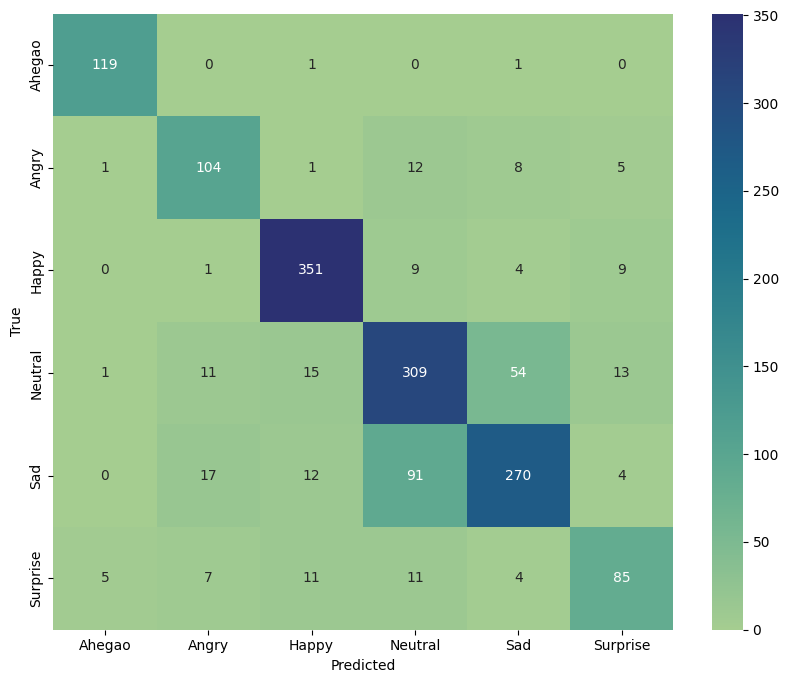

In [104]:
conf_matrix = confusion_matrix(true_cls, pred_cls)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="crest")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Neutral and Sad expressions have more false predictions then others

In [110]:
y_binarized = label_binarize(true_cls, classes=np.arange(len(labels)))

aucroc = roc_auc_score(y_binarized, preds, multi_class='ovr')
print("AUC ROC Score:", aucroc)

AUC ROC Score: 0.9645039019144731


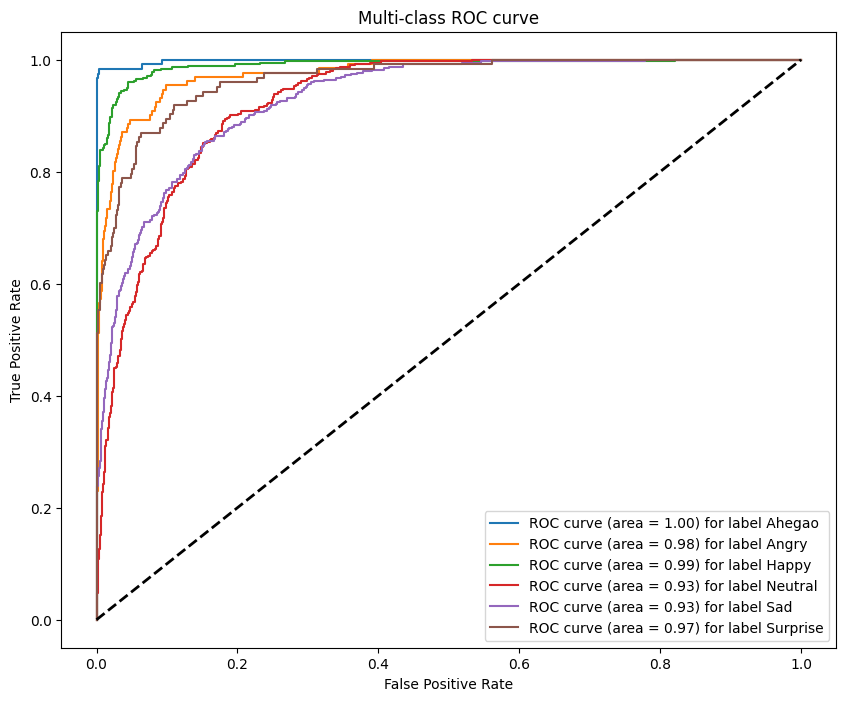

In [113]:
def plot_multiclass_roc(y_true, y_score, classes, figsize=(10, 8)):
    fpr = dict()
    tpr = dict()
    aucroc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        aucroc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=figsize)
    
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {aucroc[i]:.2f}) for label {classes[i]}')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC curve')
    plt.legend(loc="best")
    plt.show()

plot_multiclass_roc(y_binarized, preds, labels)


# LIME Interpretability

In [29]:
%%capture
model_3 = load_model('/kaggle/input/model3/model_3.1.h5')
label_map = {v: k for k, v in test_generator.class_indices.items()} # True labels classes mapping without encodings

def model_predict(image_array):
    return model_3.predict(image_array)

explainer = lime_image.LimeImageExplainer() 

random_batch = random.sample(range(len(test_generator)), 20)  # will select 20 random batches

# Explained will output the whole tqdm loading visuals in the output. So, we have to disable the outputs in this cell.
# But the image plots will be disabled as well. So, we save the explainers and other necessary components in
# this list of lists to later plot explained images from it.
explainer_instances = list() 

for i in random_batch:
    test_generator.reset() # this is for random index, will out of index if not reset
    for _ in range(i):
        next(test_generator)
    images_batch, labels_batch = next(test_generator) # get the next images and labels batch
    
    # reshaping it from (Height, Width, Channels) to (1, Height, Width, Channels)
    image_to_explain = np.expand_dims(images_batch[0], axis=0) 
    
    predictions = model_predict(image_to_explain)
    predicted_label = label_map[np.argmax(predictions)]
    
    explanation = explainer.explain_instance(image_to_explain[0].astype('double'),
                                             model_predict,
                                             top_labels=5,
                                             hide_color=0,
                                             num_samples=1000)
    
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=False,
                                                num_features=10,
                                                hide_rest=False)
    
    marked_boundaries = mark_boundaries(temp / 2 + 0.5, mask)
    
    explainer_instances.append([marked_boundaries, image_to_explain[0], labels_batch[0], predicted_label])
    print(f"Length of explainers: {len(explainer_instances)}...")
    

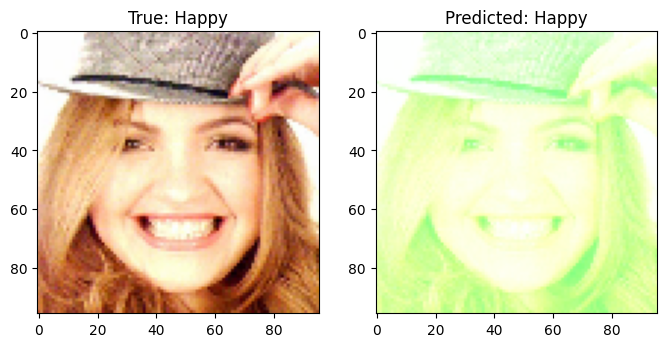

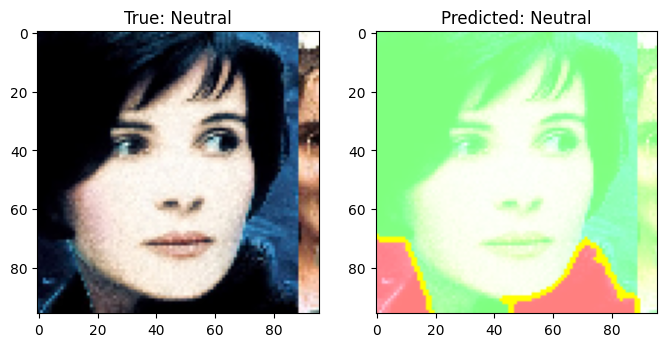

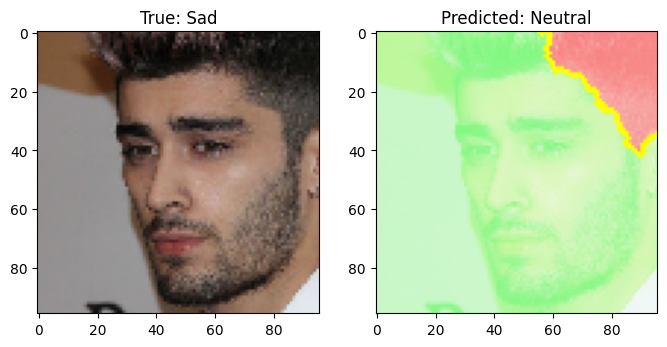

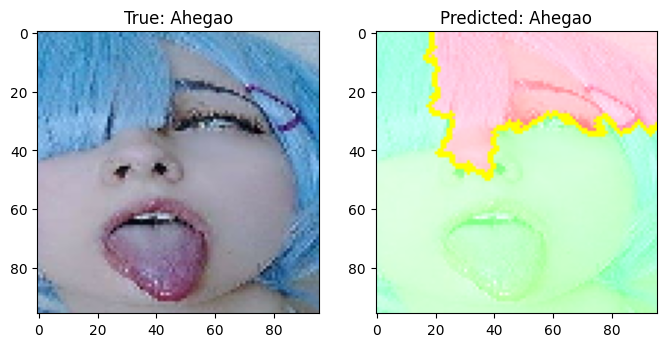

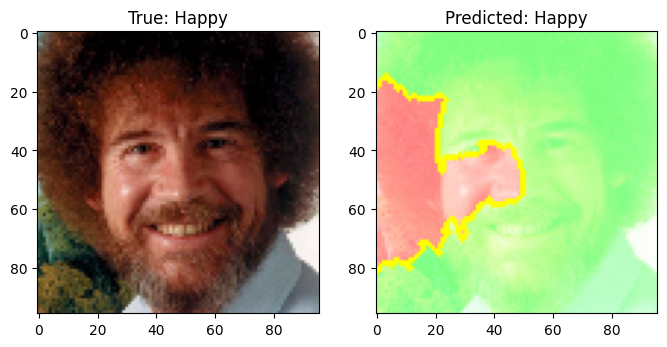

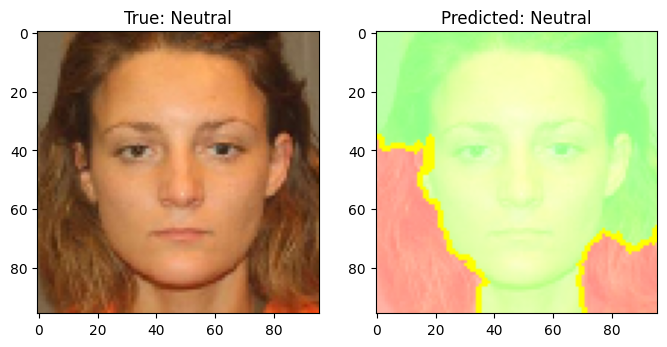

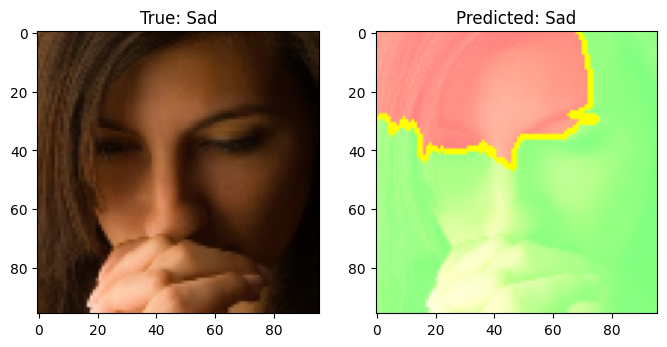

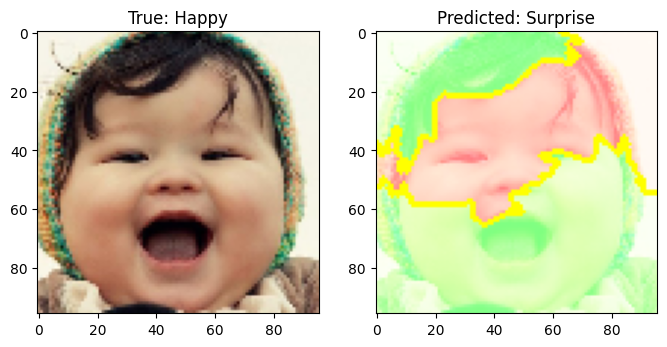

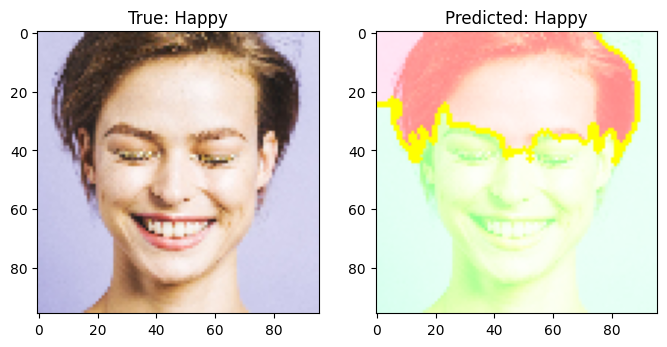

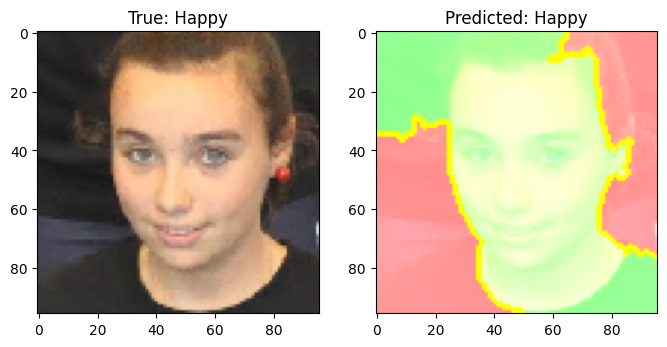

In [36]:
for exp in explainer_instances:
    marked_boundaries = exp[0]
    image_to_explain = exp[1]
    labels_batch = exp[2]
    predicted_label = exp[3]
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image_to_explain)
    plt.title(f'True: {label_map[np.argmax(labels_batch)]}')
    
    plt.subplot(1, 2, 2)
    plt.imshow(marked_boundaries)
    plt.title(f'Predicted: {predicted_label}')
    
    plt.show()

## All the correct predictions uses relevant features. Let's study all the classes which the model struggles to classify i.e. "sad", "neutral", "surprise".

In [37]:
label_map

{0: 'Ahegao', 1: 'Angry', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Surprise'}

In [45]:
%%capture
model_3 = load_model('/kaggle/input/model3/model_3.1.h5')

nss = [3, 4, 5] # "Neutral", "Sad", "Surprise"

explainer = lime_image.LimeImageExplainer()
explainer_instances = []

random_batch = random.sample(range(len(test_generator)), len(test_generator))  

nss_images = 0
for i in random_batch:
    test_generator.reset()
    for _ in range(i):
        next(test_generator)
    images_batch, labels_batch = next(test_generator) # same as before
    
    for j in range(len(images_batch)):  # for filtering nss
        encoded_labels = np.argmax(labels_batch[j])  
        if encoded_labels in nss: # same ol stuff
            image_to_explain = np.expand_dims(images_batch[j], axis=0)
            
            predictions = model_predict(image_to_explain)
            predicted_label = label_map[np.argmax(predictions)]
            
            explanation = explainer.explain_instance(image_to_explain[0].astype('double'),
                                                     model_predict,
                                                     top_labels=5,
                                                     hide_color=0,
                                                     num_samples=1000)
            
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                        positive_only=False,
                                                        num_features=10,
                                                        hide_rest=False)
            
            marked_boundaries = mark_boundaries(temp / 2 + 0.5, mask)
            
            explainer_instances.append([marked_boundaries, image_to_explain[0], labels_batch[j], predicted_label])
            
            nss_images += 1
            if nss_images >= 20:
                break
    if nss_images >= 20:
        break


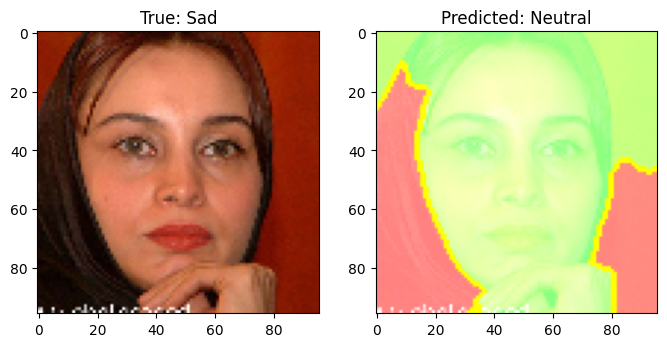

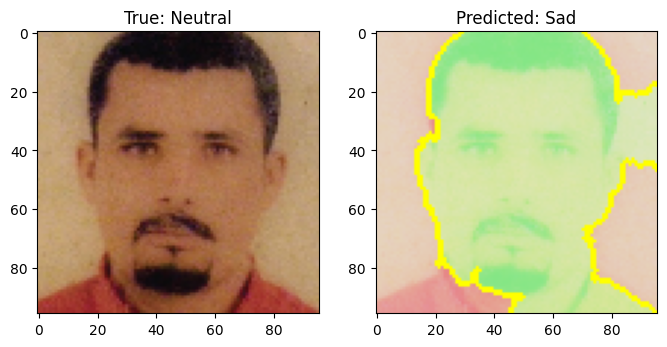

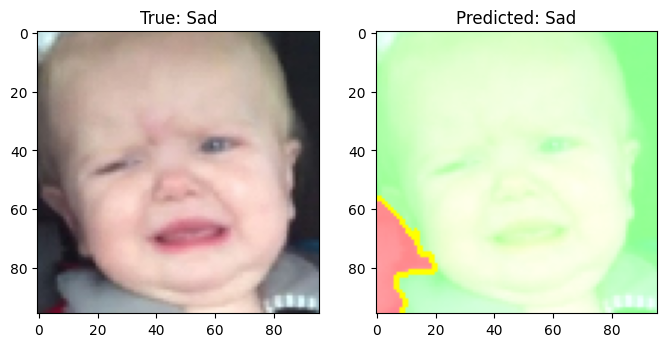

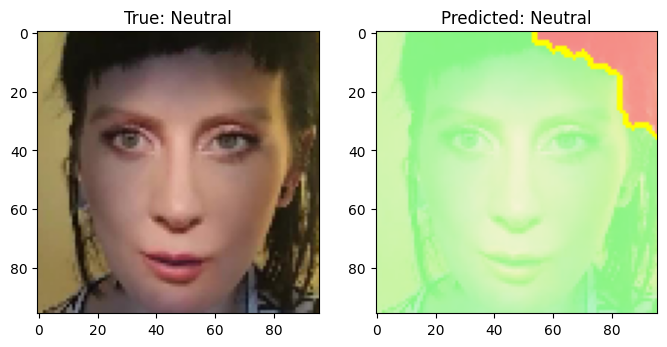

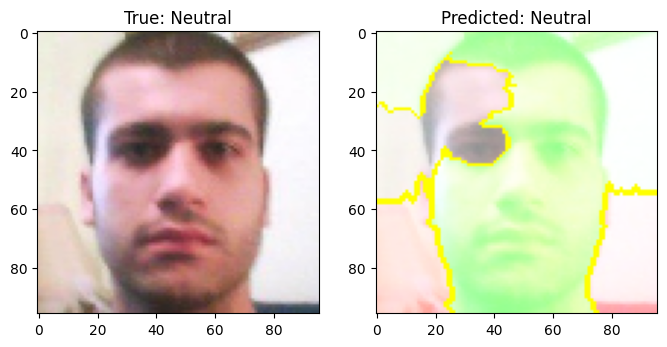

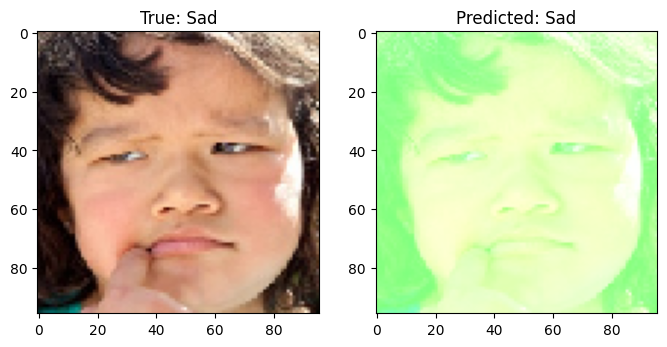

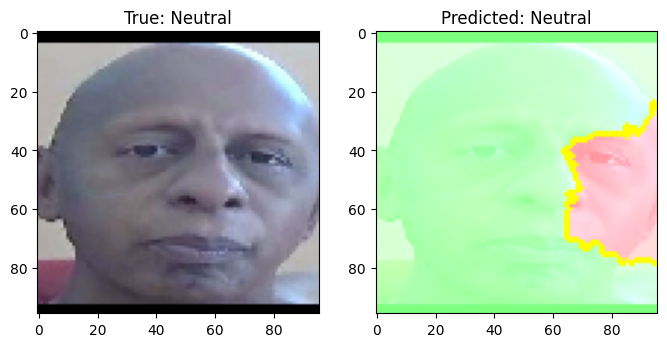

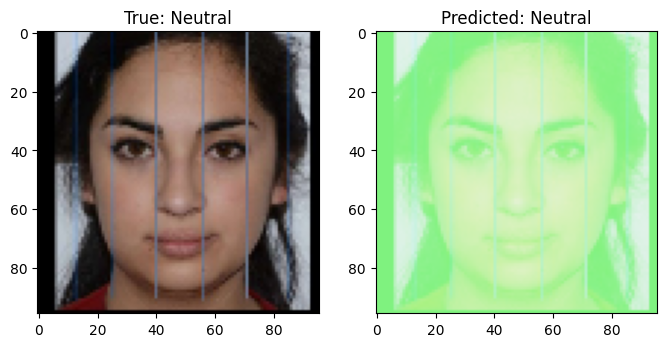

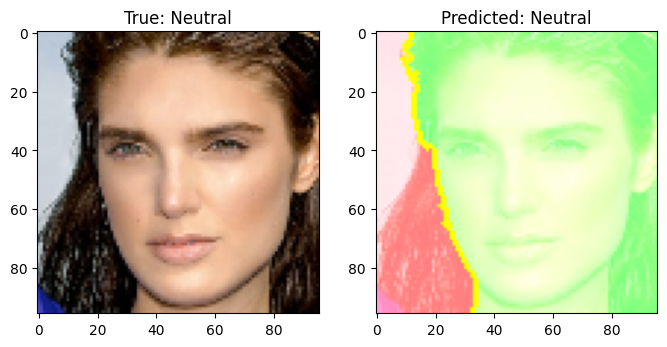

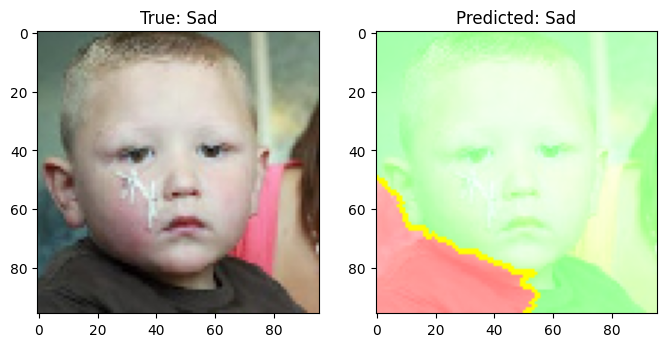

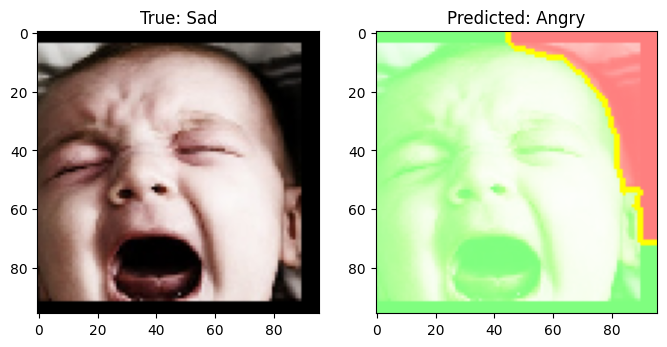

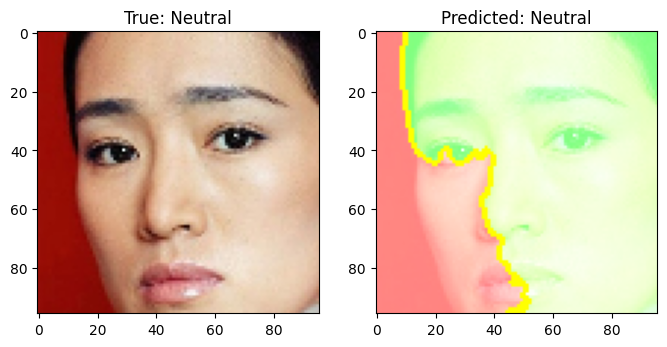

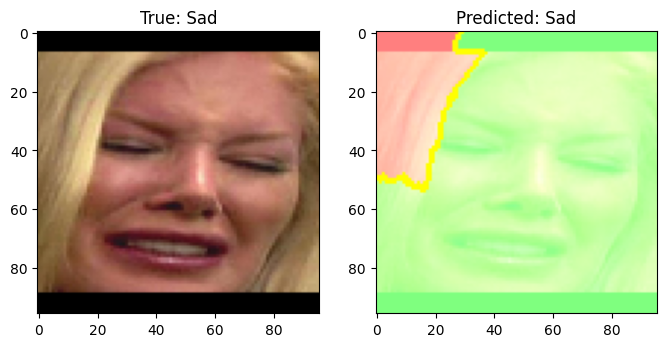

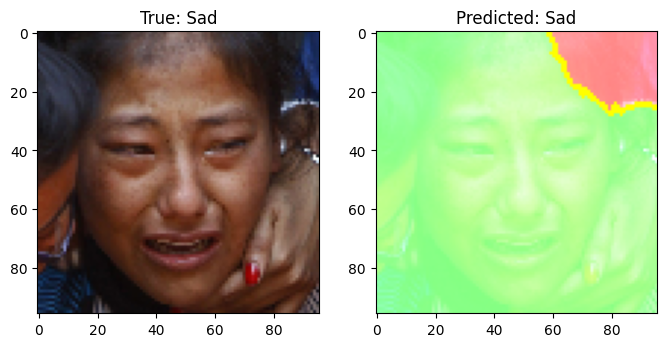

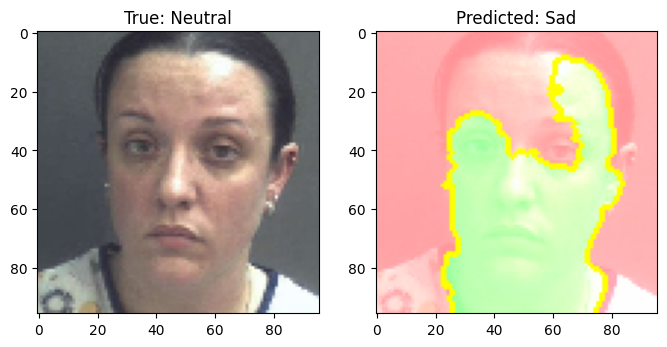

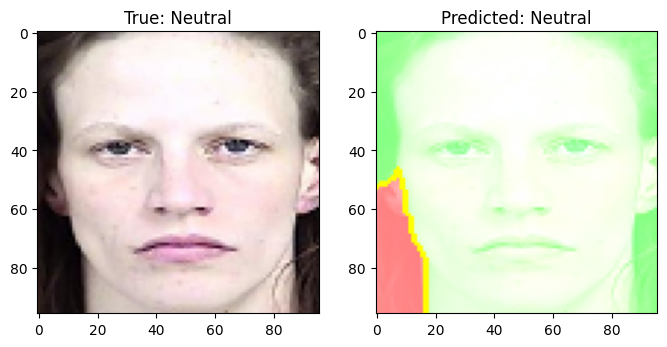

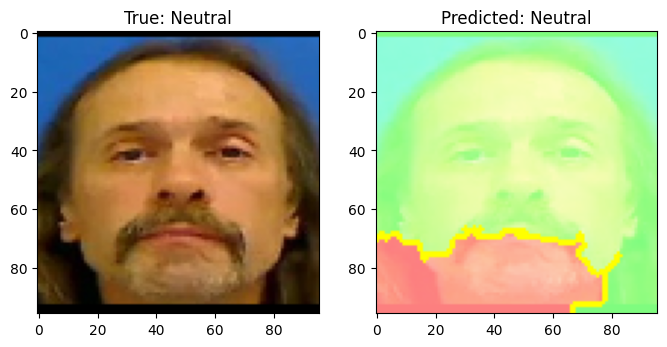

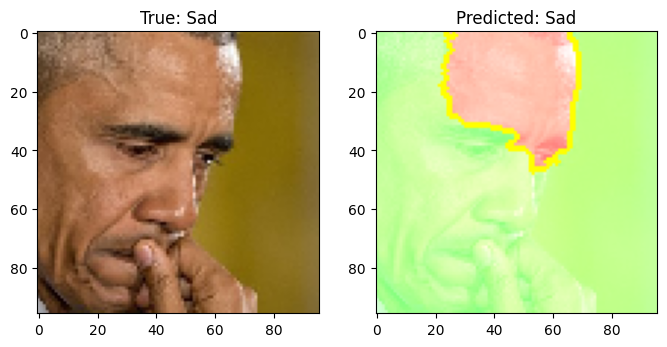

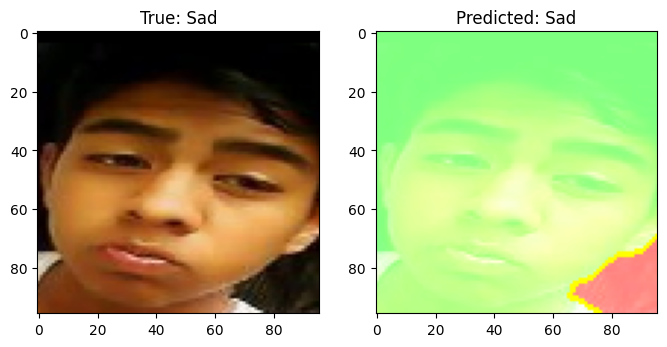

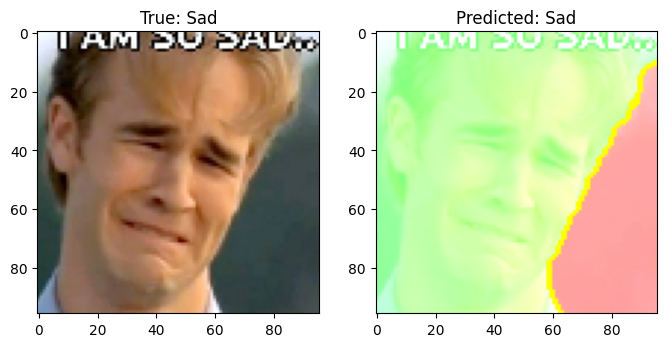

In [46]:
for exp in explainer_instances:
    marked_boundaries = exp[0]
    image_to_explain = exp[1]
    labels_batch = exp[2]
    predicted_label = exp[3]
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image_to_explain)
    plt.title(f'True: {label_map[np.argmax(labels_batch)]}')
    
    plt.subplot(1, 2, 2)
    plt.imshow(marked_boundaries)
    plt.title(f'Predicted: {predicted_label}')
    
    plt.show()

# Findings:
- Model seems to be misclassify some happy face as surprise as it did not account for eyes in those images.
- Even though model takes relevant part of image (faces) and ignores irrelevant parts like background, hair etc, it seems to be confused between neutral and sad expressions a lot. Need more training data on these 3 expressions.

# References:
- https://seaborn.pydata.org/generated/seaborn.heatmap.html
- https://keras.io/api/data_loading/image/
- https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3
- https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c
- https://ieeexplore.ieee.org/document/10053007
- https://www.kaggle.com/code/yasserhessein/emotion-recognition-with-efficientnetb0
- https://medium.com/udacity-pytorch-challengers/ideas-on-how-to-fine-tune-a-pre-trained-model-in-pytorch-184c47185a20
- https://medium.com/@dana.fatadilla123/real-time-face-expression-recognition-b2214b6cdfb9
- https://github.com/Danafr00/facial_expression_recognition/blob/main/FacialExpressionRecognition_Training.ipynb
- https://aclanthology.org/2022.sltat-1.5.pdf
- https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
- https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a
- https://deepchecks.com/question/how-to-use-the-auc-roc-curve-for-the-multi-class-model/
- https://stats.stackexchange.com/questions/2151/how-to-plot-roc-curves-in-multiclass-classification
- https://github.com/marcotcr/lime/issues/480#issuecomment-877582860
- https://github.com/marcotcr/lime?tab=readme-ov-file
- https://github.com/marcotcr/lime/commit/26f2590da45aa402fc94f046e5d8e6f6cf32b32b
- https://github.com/shap/shap/discussions/2161
- https://yashvaantlakham73.medium.com/interpretable-image-classification-using-lime-061cc90e70ac#:~:text=LIME%20is%20used%20to%20generate,contribute%20most%20to%20the%20classification.
- https://opensource.salesforce.com/OmniXAI/latest/tutorials/vision/lime.html
- https://towardsdatascience.com/how-to-explain-image-classifiers-using-lime-e364097335b4
- https://indhumathychelliah.medium.com/confusion-matrix-for-multiclass-classification-f25ed7173e66
- https://gist.github.com/vikramsoni2/3293b5dab320ba6d67eb8eed415e1c04
